In [1]:
import os
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt

In [2]:
text_dict = {}
filelist = os.listdir("texts")
for file in filelist:
    with open("texts/" + file, "r") as text_file:
        name = file[:-4]
        text_dict[name] = text_file.read()

In [3]:
text_df = pd.DataFrame.from_dict(text_dict, orient = "index")
text_df.columns = ["Text"]

In [4]:
text_df.head(5)

,Text
19540303,A meeting of the Federal Open Market Committe...
19540623,A meeting of the Federal Open Market Committe...
19540922,A meeting of the Federal Open Market Committe...
19541207,A meeting of the Federal Open Market Committe...
19550111,A meeting of the Federal Open Market Committe...


In [5]:
text_df.reset_index(inplace=True)
text_df.columns = ["Index", "Text"]

In [6]:
DATE = []
for i in text_df["Index"]:
    temp = i[:-4] + "-" + i[-4:-2] + "-01"
    DATE.append(temp)

In [7]:
text_df["DATE"] = DATE

In [8]:
text_df.head(5)

,Index,Text,DATE
0,19540303,A meeting of the Federal Open Market Committe...,1954-03-01
1,19540623,A meeting of the Federal Open Market Committe...,1954-06-01
2,19540922,A meeting of the Federal Open Market Committe...,1954-09-01
3,19541207,A meeting of the Federal Open Market Committe...,1954-12-01
4,19550111,A meeting of the Federal Open Market Committe...,1955-01-01


In [9]:
eff = pd.read_csv("C:/Users/mjcor/Documents/GitHub/fed_reserve_text_project/Effective Federal Funds Rate/Monthly.csv")

In [10]:
merged_df = text_df.merge(eff)

In [65]:
count = []
for i in range(len(merged_df)):
    length = len(merged_df.iloc[i]["Text"])
    count.append(length)

In [66]:
merged_df["Count"] = count

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

In [13]:
stop = nltk.corpus.stopwords.words("english")

In [14]:
years = list(range(1954, 2019))

In [15]:
stop = stop + years

In [16]:
stop = stop + [thing for thing in string.punctuation]

In [17]:
dates = text_df["Index"]

In [18]:
stop = stop + [str(int(i[-4:-2])) + "/" + str(int(i[-2:])) for i in dates]

In [19]:
stop = stop + [str(int(i[-4:-2])) + "/" + str(int(i[-2:])) + "/" + str(int(i[-6:-4])) for i in dates]

In [20]:
stop = stop + [letter for letter in string.ascii_lowercase]

In [21]:
stop = stop + ["mr.", "ms.", "mrs.", "’", "''", "'", "federal", "reserve", "bank", "'re", "n't", "mr", "ms", "mrs"]

In [22]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words = stop, smooth_idf = False)

In [72]:
tfidf_docs = tfidf.fit_transform(text_df["Text"])

In [73]:
tfidf_docs.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
tfidf_docs = pd.DataFrame(tfidf_docs.toarray(), index = text_df["DATE"])
tfidf_docs = tfidf_docs - tfidf_docs.mean()
tfidf_docs.shape

(710, 86136)

In [77]:
tfidf.get_feature_names().index("inflation")

45509

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, 
                                 columns=columns)
pca_topic_vectors.round(3).head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
0,-0.135,-0.179,0.015,0.110,-0.023,0.185,0.017,0.199,0.194,0.006,-0.025,-0.060,-0.053,-0.117,-0.129,-0.153
1,-0.138,-0.226,-0.009,0.036,-0.034,0.132,0.018,0.232,0.190,-0.013,-0.027,-0.097,-0.061,-0.059,-0.092,-0.139
2,-0.276,-0.205,0.034,0.001,0.020,0.083,0.021,0.217,0.179,-0.016,-0.036,-0.091,-0.050,-0.045,-0.068,-0.106
3,-0.288,-0.145,0.024,-0.012,0.024,0.108,-0.035,0.187,0.168,0.040,-0.000,-0.017,-0.025,-0.114,-0.124,-0.132
4,-0.281,-0.102,0.048,0.015,0.063,0.085,-0.022,0.151,0.133,0.028,-0.028,-0.015,-0.027,-0.128,-0.130,-0.138


In [28]:
pca_topic_vectors["DATE"] = merged_df["DATE"]
pca_topic_vectors["FEDFUNDS"] = merged_df["FEDFUNDS"]

In [29]:
pca_topic_vectors.dropna(inplace=True)

In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

In [31]:
pca_topic_vectors["DATE"] = pd.to_datetime(pca_topic_vectors["DATE"])

In [32]:
pca_date = pca_topic_vectors.drop(["FEDFUNDS"], axis = 1)
pca_cols = pca_date.columns.tolist()
pca_cols = pca_cols[-1:] + pca_cols[:-1]
pca_date = pca_date[pca_cols]
pca_date

,DATE,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
0,1954-09-01,-0.135308,-0.179428,0.014814,0.109559,-0.023309,0.184581,0.016596,0.198532,0.193504,0.006325,-0.024659,-0.060067,-0.053330,-0.117315,-0.128591,-0.152898
1,1954-12-01,-0.137822,-0.226184,-0.009473,0.035544,-0.033501,0.132236,0.017896,0.232223,0.190179,-0.012558,-0.027324,-0.096593,-0.060998,-0.059363,-0.091781,-0.138870
2,1955-01-01,-0.276427,-0.205214,0.033726,0.000666,0.019721,0.082996,0.020553,0.216772,0.178754,-0.016192,-0.036016,-0.090958,-0.050336,-0.045375,-0.067864,-0.106399
3,1955-03-01,-0.287891,-0.144897,0.023777,-0.011768,0.024145,0.107503,-0.034543,0.186608,0.167838,0.039982,-0.000137,-0.016772,-0.024678,-0.114464,-0.124164,-0.131675
4,1955-05-01,-0.280582,-0.102045,0.047625,0.015427,0.062503,0.084594,-0.022426,0.151023,0.132822,0.027791,-0.028050,-0.014677,-0.026864,-0.127657,-0.129727,-0.137808
5,1955-06-01,-0.264618,-0.194903,0.000138,0.040479,-0.018445,0.173067,0.011903,0.206080,0.194708,0.000667,-0.013704,-0.090950,-0.061134,-0.081749,-0.113914,-0.158201
6,1955-07-01,-0.292964,-0.173685,0.013091,0.014330,0.019551,0.106434,0.004868,0.209145,0.167612,0.024025,-0.030182,-0.034914,-0.031408,-0.091062,-0.112204,-0.106485
7,1955-08-01,-0.198657,-0.187199,0.018490,0.057938,0.008443,0.204472,0.012857,0.224418,0.203755,0.029066,-0.027593,-0.034483,-0.053595,-0.112765,-0.133599,-0.144181
8,1955-08-01,-0.271097,-0.174451,-0.002705,0.029428,0.014668,0.130130,0.032960,0.221020,0.174439,0.003670,-0.040739,-0.054051,-0.046543,-0.067832,-0.098078,-0.109451
9,1955-09-01,-0.383890,-0.134142,0.059928,-0.019249,0.039412,-0.035236,0.089105,0.099727,0.073593,-0.039928,-0.074359,-0.042795,-0.050883,0.026284,-0.005902,-0.041087


In [33]:
model.fit(pca_topic_vectors.drop(["FEDFUNDS", "DATE"], axis = 1), pca_topic_vectors["FEDFUNDS"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
print(model.coef_)

[  6.33890802  -4.8393215   -6.13472372   0.74328588   6.46780631
  -3.2607689    2.61208126  -1.77045673  -3.81362156   5.15227759
  13.64395353  -3.22211853   2.21937078  -0.17101638   5.13869994
   1.96331294]


In [35]:
pred_eff = model.predict(pca_topic_vectors.drop(["FEDFUNDS", "DATE"], axis = 1))

In [36]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance score: %.2f' % r2_score(pca_topic_vectors["FEDFUNDS"], pred_eff))

Variance score: 0.78


In [37]:
pca_topic_vectors[pca_topic_vectors["topic0"] == max(pca_topic_vectors["topic0"])]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,DATE,FEDFUNDS
558,0.503184,-0.07923,0.51036,-0.299107,-0.043375,0.095668,0.076772,-0.051035,-0.078883,-0.046002,0.017881,-0.017215,-0.03828,0.015406,-0.030452,-0.002253,1999-02-01,4.76


In [38]:
plt.figure(figsize=(16,12))
plt.title("Topic0 vs Topic1", {"fontsize": 48})
plt.scatter(pca_topic_vectors["topic0"], pca_topic_vectors["topic1"])
plt.savefig("pca_topics.png")

In [39]:
plt.close("all")

In [40]:
plt.figure(figsize = (16,12))
plt.scatter(pca_topic_vectors["topic0"], pca_topic_vectors["FEDFUNDS"])
plt.savefig("topic0.png")

In [41]:
plt.figure(figsize = (16,12))
plt.scatter(pca_topic_vectors["topic1"], pca_topic_vectors["FEDFUNDS"])
plt.savefig("topic1.png")

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stop)

In [79]:
X = vectorizer.fit_transform(merged_df["Text"])

In [80]:
X.shape

(708, 57808)

In [44]:
total_length = 0
for i in range(len(merged_df)):
    total_length += len(merged_df.iloc[i]["Text"])
    
print(total_length)

46562344


In [45]:
vectorizer.get_feature_names().index("inflation")

29905

In [46]:
def word_plot(word):
    plt.figure(figsize=(16,12))
    plt.title(word, {"fontsize": 48})
    plt.plot(pd.to_datetime(merged_df["DATE"]), pd.DataFrame(X.toarray())[vectorizer.get_feature_names().index(word.lower())])
#    plt.savefig(word + ".png")
    plt.show()

In [70]:
plt.figure(figsize = (16, 12))
plt.plot(pd.to_datetime(merged_df["DATE"]), merged_df["Count"])
plt.title("Word count per document", {"fontsize": 48})
plt.savefig("Word Count.png")

In [82]:
plt.close("all")

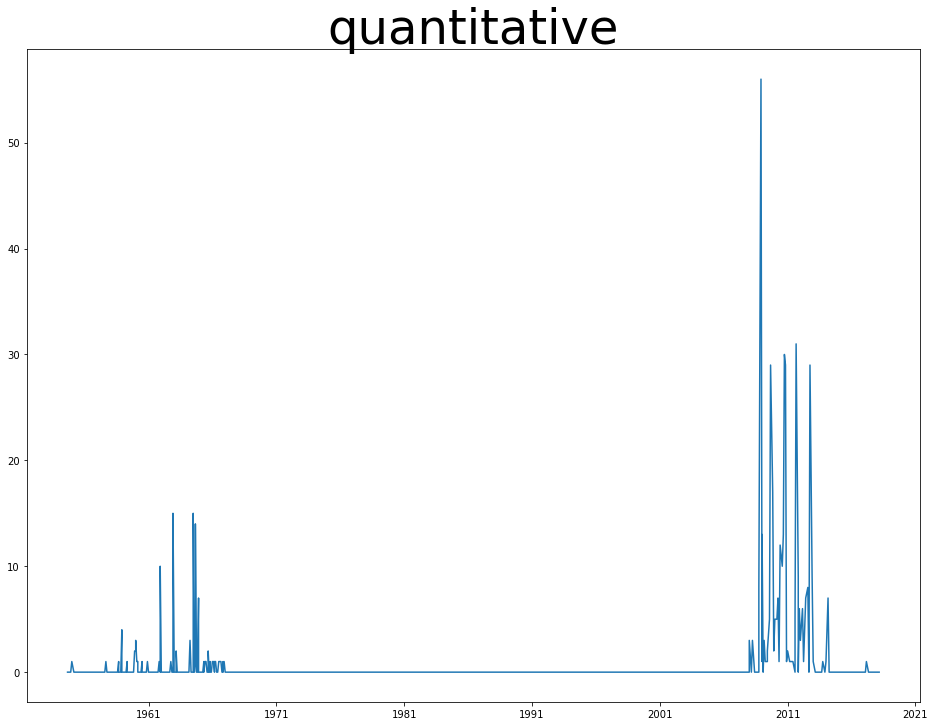

In [87]:
word_plot("quantitative")

In [77]:
plt.close("all")

In [77]:
wordlist = ["inflation", "deficit", "hurricane", "hurricanes", "brexit", "money", "strike"]
for word in wordlist:
    word_plot(word)

In [74]:
word_plot("interest")

In [47]:
feats = tfidf.get_feature_names()
for i in range(0, 710):
    temp = tfidf_docs.iloc[i][tfidf_docs.iloc[i] == [max(tfidf_docs.iloc[i])]]
    print(temp.name, feats[temp.keys()[0]])

1954-03-01 sproul
1954-06-01 committee
1954-09-01 sproul
1954-12-01 sproul
1955-01-01 ``
1955-03-01 sproul
1955-05-01 sproul
1955-06-01 committee
1955-07-01 agreements
1955-08-01 rate
1955-08-01 discount
1955-09-01 discount
1955-09-01 chicago
1955-10-01 would
1955-10-01 sproul
1955-11-01 discount
1955-11-01 when-issued
1955-12-01 rouse
1955-12-01 treasury
1956-01-01 said
1956-01-01 would
1956-02-01 said
1956-03-01 committee
1956-03-01 said
1956-04-01 said
1956-05-01 sproul
1956-05-01 reserves
1956-06-01 said
1956-06-01 said
1956-07-01 strike
1956-08-01 said
1956-08-01 said
1956-09-01 said
1956-09-01 would
1956-10-01 roosa
1956-11-01 year
1956-11-01 said
1956-12-01 said
1957-01-01 said
1957-01-01 said
1957-02-01 said
1957-03-01 committee
1957-03-01 said
1957-04-01 said
1957-04-01 treasury
1957-05-01 treasury
1957-05-01 said
1957-06-01 treasury
1957-07-01 treasury
1957-07-01 rate
1957-08-01 cent
1957-09-01 borrowed
1957-10-01 said
1957-10-01 said
1957-11-01 would
1957-12-01 said
1957-12-

1989-10-01 1989
1989-11-01 12/04/89
1989-12-01 1989
1990-02-01 1990
1990-03-01 1990
1990-05-01 1990
1990-07-01 1990
1990-08-01 1990
1990-10-01 1990
1990-11-01 12/04/90
1990-12-01 1990
1991-02-01 foreign
1991-03-01 1991
1991-05-01 1991
1991-07-01 1991
1991-08-01 1991
1991-10-01 1991
1991-11-01 12/04/91
1991-12-01 1991
1992-02-01 foreign
1992-03-01 1992
1992-05-01 1992
1992-07-01 1992
1992-08-01 1992
1992-10-01 1992
1992-11-01 12/04/92
1992-12-01 1992
1993-02-01 1992
1993-03-01 january
1993-07-01 1993
1993-08-01 july
1993-09-01 august
1993-11-01 transcripts
1993-12-01 november
1994-02-01 1993
1994-03-01 1994
1995-02-01 1994
1995-03-01 1995
1995-05-01 1995
1995-07-01 1995
1995-08-01 1995
1995-09-01 1995
1995-11-01 mos
1995-12-01 1995
1996-01-01 1996
1996-03-01 1996
1996-05-01 1996
1996-07-01 1996
1996-08-01 1996
1996-09-01 1996
1996-11-01 1996
1996-12-01 1996
1997-02-01 1997
1997-03-01 1997
1997-05-01 1997
1997-07-01 1997
1997-08-01 1997
1997-09-01 1997
1997-11-01 1997
1997-12-01 1997
199

In [48]:
y = merged_df["FEDFUNDS"]

In [49]:
from sklearn.linear_model import Lasso

In [50]:
reg = Lasso(alpha = 0.01)

In [51]:
reg.fit(X, y)

C:\cygwin64\home\mjcor\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
len(reg.coef_)

57808

In [53]:
top_20 = sorted(reg.coef_, reverse = False)[:20]

In [54]:
top_20

[-0.33457541464053775,
 -0.31295396941885945,
 -0.30427637213400033,
 -0.27720586720065077,
 -0.26281516410732447,
 -0.24804488320075924,
 -0.23107690029929365,
 -0.21686840850805772,
 -0.20472805757408966,
 -0.20165614304554069,
 -0.17690541212249039,
 -0.17545036936146197,
 -0.17087805689637597,
 -0.15721520239872341,
 -0.13324284680713383,
 -0.13062542916487116,
 -0.12943258617630699,
 -0.11759441558884774,
 -0.1140181579534206,
 -0.11247668611865141]

In [55]:
top_20_list = []
for i in range(len(reg.coef_)):
    if reg.coef_[i] in top_20:
        print(vectorizer.get_feature_names()[i], reg.coef_[i])
        top_20_list.append(vectorizer.get_feature_names()[i])

00 -0.114018157953
1975 -0.133242846807
1976 -0.312953969419
1992 -0.117594415589
2002 -0.334575414641
broader -0.170878056896
deputy -0.176905412122
larkin -0.157215202399
marsh -0.248044883201
olson -0.262815164107
ranges -0.231076900299
reflecting -0.130625429165
review -0.201656143046
richmond -0.112476686119
robert -0.304276372134
siegman -0.204728057574
sustainable -0.216868408508
thomas -0.129432586176
tuesday -0.175450369361
voting -0.277205867201


In [88]:
word_plot("sustainable")

In [56]:
top_20 = sorted(reg.coef_, reverse = True)[:20]
print(top_20)
print("***************************")
top_20_list = []
for i in range(len(reg.coef_)):
    if reg.coef_[i] in top_20:
        print(vectorizer.get_feature_names()[i], reg.coef_[i])
        top_20_list.append(vectorizer.get_feature_names()[i])

[2.179475550580761, 1.3125937080888714, 0.6442348190619317, 0.5378276598807159, 0.48697807871123339, 0.48069019373225302, 0.43912479262842097, 0.378639709344475, 0.37379622834801246, 0.36560763421285991, 0.33189671627840445, 0.30024629788212354, 0.27744122022553591, 0.26360584942648008, 0.25241796310323661, 0.24952135271159595, 0.22573142758721931, 0.20615389283580615, 0.19194316694379435, 0.18819454638774388]
***************************
1973 0.206153892836
1981 0.373796228348
1989 0.191943166944
2000 0.300246297882
balles 0.439124792628
bucher 0.378639709344
corrigan 0.537827659881
coyne 0.644234819062
ettin 0.277441220226
gramley 0.331896716278
minneapolis 0.225731427587
participating 0.365607634213
rice 0.486978078711
roos 0.252417963103
schultz 1.31259370809
secretariat 0.188194546388
st 0.249521352712
teeters 2.17947555058
volcker 0.480690193732
winn 0.263605849426


In [ ]:
plt.close('all')
plt.clf()

In [56]:
for word in top_20_list:
    word_plot(word)

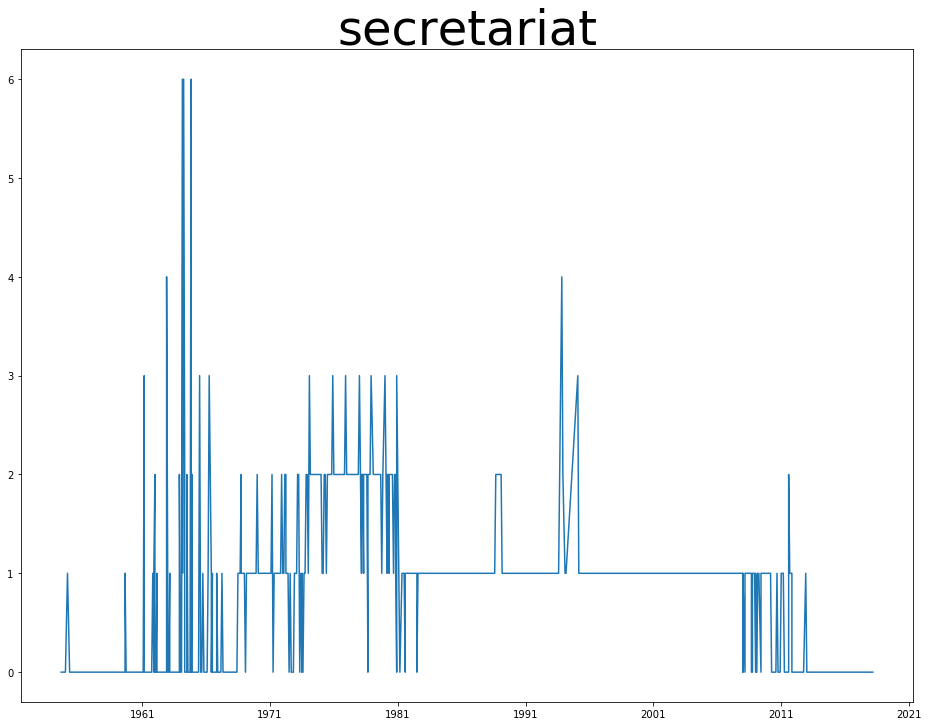

In [63]:
plt.figure(figsize=(16,12))
plt.title("secretariat", {"fontsize": 48})
plt.plot(pd.to_datetime(merged_df["DATE"]), pd.DataFrame(X.toarray())[vectorizer.get_feature_names().index("secretariat")])
plt.show()

In [ ]:
len(reg.coef_)

In [ ]:
vectorizer.get_feature_names()[50796]

In [ ]:
X

In [ ]:
pca_topic_vectors

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=16, n_iter=300)  
svd_topic_vectors = svd.fit_transform(tfidf_docs)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, 
                                 columns=columns)
svd_topic_vectors.round(2).head(6)

In [ ]:
svd_topic_vectors["Date"] = text_df["Date"]
svd_topic_vectors.set_index("Date", inplace=True)

In [ ]:
svd_topic_vectors

In [59]:
feats = tfidf.get_feature_names()
for i in range(0, 710):
    temp = tfidf_docs.iloc[i][tfidf_docs.iloc[i] == [max(tfidf_docs.iloc[i])]]
    print(temp.name, feats[temp.keys()[0]])

1954-03-01 sproul
1954-06-01 committee
1954-09-01 sproul
1954-12-01 sproul
1955-01-01 ``
1955-03-01 sproul
1955-05-01 sproul
1955-06-01 committee
1955-07-01 agreements
1955-08-01 rate
1955-08-01 discount
1955-09-01 discount
1955-09-01 chicago
1955-10-01 would
1955-10-01 sproul
1955-11-01 discount
1955-11-01 when-issued
1955-12-01 rouse
1955-12-01 treasury
1956-01-01 said
1956-01-01 would
1956-02-01 said
1956-03-01 committee
1956-03-01 said
1956-04-01 said
1956-05-01 sproul
1956-05-01 reserves
1956-06-01 said
1956-06-01 said
1956-07-01 strike
1956-08-01 said
1956-08-01 said
1956-09-01 said
1956-09-01 would
1956-10-01 roosa
1956-11-01 year
1956-11-01 said
1956-12-01 said
1957-01-01 said
1957-01-01 said
1957-02-01 said
1957-03-01 committee
1957-03-01 said
1957-04-01 said
1957-04-01 treasury
1957-05-01 treasury
1957-05-01 said
1957-06-01 treasury
1957-07-01 treasury
1957-07-01 rate
1957-08-01 cent
1957-09-01 borrowed
1957-10-01 said
1957-10-01 said
1957-11-01 would
1957-12-01 said
1957-12-

1989-07-01 1989
1989-08-01 1989
1989-10-01 1989
1989-11-01 12/04/89
1989-12-01 1989
1990-02-01 1990
1990-03-01 1990
1990-05-01 1990
1990-07-01 1990
1990-08-01 1990
1990-10-01 1990
1990-11-01 12/04/90
1990-12-01 1990
1991-02-01 foreign
1991-03-01 1991
1991-05-01 1991
1991-07-01 1991
1991-08-01 1991
1991-10-01 1991
1991-11-01 12/04/91
1991-12-01 1991
1992-02-01 foreign
1992-03-01 1992
1992-05-01 1992
1992-07-01 1992
1992-08-01 1992
1992-10-01 1992
1992-11-01 12/04/92
1992-12-01 1992
1993-02-01 1992
1993-03-01 january
1993-07-01 1993
1993-08-01 july
1993-09-01 august
1993-11-01 transcripts
1993-12-01 november
1994-02-01 1993
1994-03-01 1994
1995-02-01 1994
1995-03-01 1995
1995-05-01 1995
1995-07-01 1995
1995-08-01 1995
1995-09-01 1995
1995-11-01 mos
1995-12-01 1995
1996-01-01 1996
1996-03-01 1996
1996-05-01 1996
1996-07-01 1996
1996-08-01 1996
1996-09-01 1996
1996-11-01 1996
1996-12-01 1996
1997-02-01 1997
1997-03-01 1997
1997-05-01 1997
1997-07-01 1997
1997-08-01 1997
1997-09-01 1997
199

In [62]:
for word in text_df["Text"][text_df["DATE"]=="2008-09-01"]:
    print(word)

 Meeting of the Federal Open Market Committee on September 16, 2008  A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, September 16, 2008, at 8:30 a.m.  Those present were the following:  Mr. Bernanke, Chairman Ms. Duke Mr. Fisher Mr. Kohn Mr. Kroszner Ms. Pianalto Mr. Plosser Mr. Stern Mr. Warsh  Ms. Cumming, Messrs. Evans, Lacker, and Lockhart, and Ms. Yellen, Alternate Members of the Federal Open Market Committee  Messrs. Bullard, Hoenig, and Rosengren, Presidents of the Federal Reserve Banks of St. Louis, Kansas City, and Boston, respectively  Mr. Madigan, Secretary and Economist Ms. Danker, Deputy Secretary Mr. Skidmore, Assistant Secretary Ms. Smith, Assistant Secretary Mr. Alvarez, General Counsel Mr. Sheets, Economist Mr. Stockton, Economist  Messrs. Connors, English, Kamin, Rolnick, Rosenblum, Slifman, Tracy, and Wilcox, Associate Economists  Mr. Dudley, Manager, Syste